#Fashion Search AI

### **Objective:** 
**Develop a Generative Search System:** Create a system that can search through product descriptions and recommend suitable options based on user queries

**Leverage the Myntra Dataset:** Use the Myntra dataset available on Kaggle as the foundation for building and training your search system..

## Project Scope:

The scope of this project is to build a Gen AI based search system with the below layers,

### **The Embedding Layer:**

The CSV document has to be pre-processed, cleaned, and prepared for embedding.

### **The Search Layer:**

**Create a Minimum of Three Test Queries:** Develop at least three distinct queries to evaluate the performance of your system.

**Embed and Search Queries:** Convert these queries into vector embeddings and perform a search in your vector database for each query. Ensure to implement a caching mechanism to optimize performance.

**Integrate a Re-Ranking Component:** Implement a re-ranking block to refine search results. For this, select an appropriate cross-encoding model from the options available on HuggingFace.


### **The Generation Layer:**

**Design the Final Prompt:** The primary element in the generation layer is the final prompt you create.

**Address Each Layer and Conduct Experiments:** Focus on systematically addressing every layer of the system and performing thorough experiments.

**Objective:** Develop a highly functional and efficient fashion search system specifically tailored to user needs.


## 1. Install and Import the Required Libraries

In [ ]:
# Install all the required libraries

!pip install pdfplumber langchain tiktoken openai sentence-transformers -q

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
pip install chromadb==0.5.3

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached chromadb-0.5.3-py3-none-any.whl (559 kB)
  Using cached chroma_hnswlib-0.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)
  Using cached httpx-0.27.0-py3-none-any.whl (75 kB)
  Using cached bcrypt-4.2.0-cp39-abi3-manylinux_2_28_x86_64.whl (273 kB)
  Using cached kubernetes-30.1.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
  Using cached grpcio-1.66.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.7 MB)
  Using cached orjson-3.10.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (141 kB)
  Using cached fastapi-0.112.1-py3-none-any.whl (93 kB)
  Using cached opentelemetry_exporter_otlp_proto_grpc-1.26.0-py3-none-any.whl (18 kB)
  Using cached overrides-7.7.0-py3-none-any.whl (17 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached uvicorn-0.30.6-py3-none

In [ ]:
dbutils.library.restartPython()

In [ ]:
# Importing necessary libraries
import tiktoken  # Assuming this is a custom library for tokenization
import openai  # OpenAI library for accessing GPT models
import chromadb  # ChromaDB library for database operations
from pathlib import Path  # For handling file paths
import pandas as pd  # Pandas for data manipulation
from operator import itemgetter  # For sorting dictionaries
import json  # For working with JSON data
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF vectorizer
from sklearn.metrics.pairwise import cosine_similarity  # Cosine similarity calculation
from nltk.corpus import stopwords  # Stopwords for text processing
from nltk.tokenize import word_tokenize  # Tokenization
import string  # String manipulation functions
from PIL import Image  # Image processing library
import requests  # For making HTTP requests
from io import BytesIO  # For handling binary data
import matplotlib.pyplot as plt  # Matplotlib for visualization
from matplotlib import table  # Table visualization in Matplotlib
import os  # Operating system utilities
import matplotlib.image as mpimg

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util
# Importing required functions and classes from ChromaDB
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

2024-08-24 17:50:05.998459: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:

# #Use once and comment the below code
# import zipfile
# path_to_zip_file='/Volumes/datascience_test/default/images/archive.zip'
# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall('/Volumes/datascience_test/default/images/dataset/')

## 2. Read, Process the csv Files



In [ ]:
# Define the file path to the Fashion Dataset CSV file
file_path = "/Workspace/Users/pradeep/ml/GenAI/DB/generative-ai-application-development-1.0.2/02 - Building Multi-stage Reasoning/Fashion_Dataset_v2.csv"

# Read the Fashion Dataset CSV file into a Pandas DataFrame
fashion_data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify the data has been loaded correctly
fashion_data.head()


,p_id,name,products,price,colour,brand,img,ratingCount,avg_rating,description,p_attributes
0,17048614,Khushal K Women Black Ethnic Motifs Printed Ku...,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,http://assets.myntassets.com/assets/images/170...,4522.0,4.418399,Black printed Kurta with Palazzos with dupatta...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
1,16524740,InWeave Women Orange Solid Kurta with Palazzos...,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,http://assets.myntassets.com/assets/images/165...,1081.0,4.119334,Orange solid Kurta with Palazzos with dupatta<...,"{'Add-Ons': 'NA', 'Body Shape ID': '443,333,32..."
2,16331376,Anubhutee Women Navy Blue Ethnic Motifs Embroi...,"Kurta, Trousers, Dupatta",4899.0,Navy Blue,Anubhutee,http://assets.myntassets.com/assets/images/163...,1752.0,4.161530,Navy blue embroidered Kurta with Trousers with...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
3,14709966,Nayo Women Red Floral Printed Kurta With Trous...,"Kurta, Trouser, Dupatta",3699.0,Red,Nayo,http://assets.myntassets.com/assets/images/147...,4113.0,4.088986,Red printed kurta with trouser and dupatta<br>...,"{'Add-Ons': 'NA', 'Body Shape ID': '333,424', ..."
4,11056154,AHIKA Women Black & Green Printed Straight Kurta,Kurta,1350.0,Black,AHIKA,http://assets.myntassets.com/assets/images/110...,21274.0,3.978377,"Black and green printed straight kurta, has a ...","{'Body Shape ID': '424', 'Body or Garment Size..."


####  2.1 viewing image
Let's view few images provided in the dataset.

In [ ]:
# Define the path to the images folder
images_folder_path = '/Volumes/datascience_test/default/images/dataset/images/'

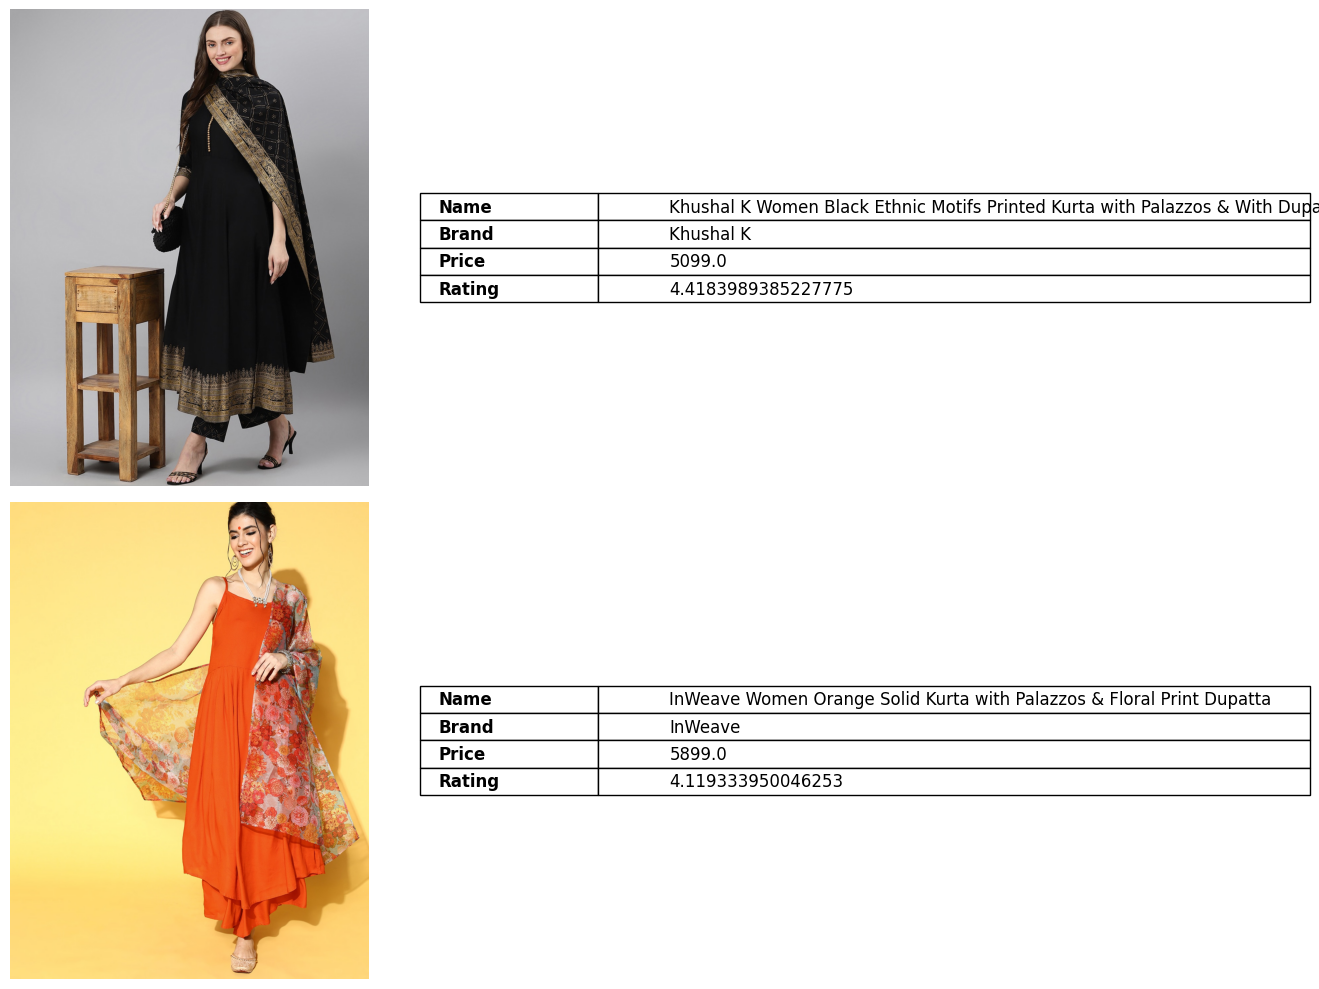

In [ ]:


# Define a function to display images with mini tables
def display_images_with_info(df, images_folder_path, num_images=3):
    """
    Display images with accompanying mini tables containing information from the DataFrame.

    Args:
    - df: DataFrame containing image information
    - images_folder_path: Path to the folder containing the images
    - num_images: Number of images to display

    Returns:
    None
    """
    # Create subplots to display images and mini tables
    fig, axes = plt.subplots(num_images, 2, figsize=(15, num_images * 5))

    # Iterate over each row in the DataFrame and display the image with mini table
    for i, (idx, row) in enumerate(df.head(num_images).iterrows()):
        # Construct the path to the image file
        image_path = os.path.join(images_folder_path, str(row['p_id']) + '.jpg')

        # Check if the image file exists
        if os.path.exists(image_path):
            # Open the image file
            img = Image.open(image_path)

            # Display the image
            axes[i, 0].imshow(img)
            axes[i, 0].axis('off')

            # Create a mini table with information from the DataFrame
            table_data = [['Name', row['name']],
                          ['Brand', row['brand']],
                          ['Price', row['price']],
                          ['Rating', row['avg_rating']]]

            axes[i, 1].axis('off')
            mini_table = axes[i, 1].table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.2, 0.8])

            # Format the mini table
            for cell in mini_table.get_celld().values():
                if cell.get_text().get_text() in ['Name', 'Brand', 'Price', 'Rating']:
                    cell.get_text().set_fontweight('bold')
                cell.get_text().set_fontsize(12)

            # Set font size explicitly for all cells
            mini_table.auto_set_font_size(False)
            mini_table.set_fontsize(12)
            mini_table.scale(1.2, 1.2)  # Adjust the scaling factor as needed
        else:
            print(f"Image not found for p_id: {row['p_id']}")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Display images with mini tables for the first 3 images
display_images_with_info(fashion_data, images_folder_path, num_images=2)


In [ ]:
# Print the columns of the fashion_data DataFrame
print(fashion_data.columns)


Index(['p_id', 'name', 'products', 'price', 'colour', 'brand', 'img',
       'ratingCount', 'avg_rating', 'description', 'p_attributes'],
      dtype='object')


In [ ]:
# Print the information about the fashion_data DataFrame
print(fashion_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14214 entries, 0 to 14213
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p_id          14214 non-null  int64  
 1   name          14214 non-null  object 
 2   products      14214 non-null  object 
 3   price         14214 non-null  float64
 4   colour        14214 non-null  object 
 5   brand         14214 non-null  object 
 6   img           14214 non-null  object 
 7   ratingCount   6530 non-null   float64
 8   avg_rating    6530 non-null   float64
 9   description   14214 non-null  object 
 10  p_attributes  14214 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.2+ MB
None


## Chunking 

No Chunking: We have opted not to perform dataset chunking. The dataset is already organized with each data point in its appropriate rows and columns.Here chunking can lose the key details.

Reason for Decision: Chunking is typically used to manage large datasets by dividing them into smaller parts. Since our dataset is of a manageable size and does not necessitate processing in smaller segments, we have chosen to forgo this approach.


In [ ]:
#Reading the OpenAI Key as a secret
api_key=dbutils.secrets.get(scope="pradyai", key="key")


## 3.Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

### Embedding Layer

In [ ]:


# Initialize the ChromaDB client with the default data path, this will use the path where chroma client is running
client = chromadb.PersistentClient()

In [ ]:
# Set up the embedding function using the OpenAI embedding model
model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=api_key, model_name=model)

# Get or create a ChromaDB collection for fashion products

fashion_collection=client.get_or_create_collection(name='fashion_products_1', embedding_function=embedding_function)

In [ ]:

# Set the API key for OpenAI
openai.api_key = api_key

In [ ]:



# Convert the data to a dictionary format with metadata
fashion_data['metadata'] = fashion_data.apply(
    lambda x: {
        'Product_id': x['p_id'],  # Unique identifier for the product
        'Name': x['name'],  # Product name
        'Product_type': x['products'],  # Type or category of the product
        'Price_INR': x['price'],  # Price of the product in Indian Rupees
        'Colour': x['colour'],  # Color of the product
        'Brand': x['brand'],  # Brand of the product
        'RatingCount': x['ratingCount'],  # Number of ratings received
        'Rating': x['avg_rating'],  # Average rating of the product
        'Description': x['description'],  # Description of the product
        'Product_attributes': x['p_attributes']  # Additional attributes of the product
    }, axis=1
)

# Function to extract text for embedding
def extract_text(metadata):
    """
    Extracts text content from the metadata dictionary for embedding.

    Args:
    metadata (dict): Dictionary containing metadata information.

    Returns:
    str: Text content extracted from the metadata.
    """
    text_content = ""
    if "Description" in metadata and metadata["Description"]:
        text_content += metadata["Description"]  # Add product description
    if "name" in metadata:
        text_content += " " + metadata["name"]  # Add product name
    if not text_content:
        text_content = "No description available."
    return text_content.strip()  # Strip leading and trailing whitespace

# Extract text for embedding from each row of metadata
documents = [extract_text(row['metadata']) for _, row in fashion_data.iterrows()]



In [ ]:
documents[2]

"Navy blue embroidered Kurta with Trousers with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs embroidered </li> <li> A-line shape </li> <li> Regular style </li> <li> Round neck,  three-quarter no sleeves </li> <li> Thread work detail </li> <li> Above knee length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Trousers design:  </b> <ul> <li> Printed Trousers </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Viscose rayon<br>Hand WashThe model (height 5'8) is wearing a size S"

In [ ]:

# Add the data to the ChromaDB collection
for idx, (p_id, metadata) in enumerate(zip(fashion_data['p_id'], fashion_data['metadata'])):
    print(f"Processing document with p_id={p_id}")
    print(f"Document text: {documents[idx]}")
    fashion_collection.add(
        documents=[documents[idx]],  # Text content of the document
        ids=[str(p_id)],  # Unique identifier of the document
        metadatas=[metadata]  # Metadata associated with the document
    )

print("Data added to ChromaDB collection!")

Processing document with p_id=17048614
Document text: Black printed Kurta with Palazzos with dupatta <br> <br> <b> Kurta design:  </b> <ul> <li> Ethnic motifs printed </li> <li> Anarkali shape </li> <li> Regular style </li> <li> Mandarin collar,  three-quarter regular sleeves </li> <li> Calf length with flared hem </li> <li> Viscose rayon machine weave fabric </li> </ul> <br> <b> Palazzos design:  </b> <ul> <li> Printed Palazzos </li> <li> Elasticated waistband </li> <li> Slip-on closure </li> </ul>Dupatta Length 2.43 meters Width:&nbsp;88 cm<br>The model (height 5'8) is wearing a size S100% Rayon<br>Machine wash
Processing document with p_id=16524740
Document text: Orange solid Kurta with Palazzos with dupatta<br><br><b>Kurta design: </b><ul><li>Solid</li><li>A-line shape</li><li>Regular style</li><li>Square neck, sleeveless shoulder straps</li><li>Calf length with straight hem</li><li>Viscose rayon machine weave fabric</li></ul><br><b>Palazzos design: </b><ul><li>Solid Palazzos</li><

In [ ]:
# Peek into the first 5 documents in the Fashion_Products collection
fashion_collection.peek(5)


{'ids': ['10016743', '10019867', '10035883', '10051259', '10053731'],
 'embeddings': [[-0.01229843683540821,
   0.000728239887394011,
   0.013846354559063911,
   -0.0027300831861793995,
   0.007354243192821741,
   0.013885542750358582,
   -0.01836601458489895,
   -0.013663478195667267,
   -0.006567221600562334,
   -0.028241338208317757,
   0.021527161821722984,
   0.014329670928418636,
   0.010691736824810505,
   -0.022807298228144646,
   -0.015805743634700775,
   0.009574884548783302,
   0.01655031181871891,
   0.010234545916318893,
   -0.0012703377287834883,
   -0.010339046828448772,
   -0.020194778218865395,
   0.018352951854467392,
   -0.0026713013648986816,
   -0.006420267280191183,
   0.010541517287492752,
   0.005901028867810965,
   0.0050029754638671875,
   -0.01751694455742836,
   0.019959650933742523,
   -0.0030925702303647995,
   -0.0018516234122216702,
   -0.008268624544143677,
   -0.005169523414224386,
   -0.035138390958309174,
   -0.012742565013468266,
   0.00735424319282

In [ ]:
# Specify the name for the cache collection
cache_collection_name = 'Fashion_Cache_1'

# Create or retrieve the cache collection for fashion search using the PersistentClient
cache_collection = client.get_or_create_collection(name=cache_collection_name, embedding_function=embedding_function)


In [ ]:
# Display a preview of the cache collection to inspect its contents
cache_collection.peek()


{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None,
 'included': ['embeddings', 'metadatas', 'documents']}


## 4. Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [ ]:

#Query 1: What are the customization options and fabric details for the green and blue embroidered lehenga choli set with mirror work, including the blouse, lehenga, and dupatta?

#Query 2: What are the color details and key features of the grey colorblocked sweatshirt?

#Query 3: I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL.

#Query 4: What are the fabric details, customization options, and price for the off-white printed lehenga choli set with dupatta, including the blouse, lehenga, and dupatta?

#Query 5: Is the yellow and orange embroidered lehenga choli set with dupatta, including the ready-to-wear blouse and made-to-measure lehenga, available in other colors?

#Query 6: What are the key features and fabric composition of the navy blue cropped sweatshirt?

#Query 7: What are the color details and key features of the grey and green colorblocked sweatshirt?

In [ ]:
# Prompt the user to enter a fashion-related query with specific requirements
query = input("Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer: ")

Please enter your fashion-related query. For example, you can mention the color, size, price range, style, and any specific patterns or designs you prefer:  I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL

In [ ]:
query

"I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL"

In [ ]:
# Search the Cache collection first

cache_results = cache_collection.query(
    query_texts=query,  # User query
    n_results=3  # Number of results to retrieve
)
cache_results



Number of requested results 3 is greater than number of elements in index 2, updating n_results = 2


{'ids': [[' What are the color details and key features of the grey colorblocked sweatshirt?',
   'What are the customization options and fabric details for the green and blue embroidered lehenga choli set with mirror work, including the blouse, lehenga, and dupatta?']],
 'distances': [[0.49135721657144443, 0.5018745264485029]],
 'metadatas': [[{'distances0': '0.26502089517942023',
    'distances1': '0.2689977288246155',
    'distances2': '0.27248015999794006',
    'documents0': "Grey and green colourblocked sweatshirt has a round neck, long sleeves, straight hemCotton<br>Machine WashThe model (height 5'8) is wearing a size S",
    'documents1': 'Red and grey colourblocked sweatshirt, has a round neck, long sleeves,  straight hemThe model (height 5\'8") is wearing a size SMaterial: Cotton<br>  Machine Wash',
    'documents2': 'Pink and grey colourblocked sweatshirt, has a round neck, two pockets, long sleeves, zip closure, straight hemMaterial: 100% Cotton<br>Machine WashThe model (hei

### Search Layer

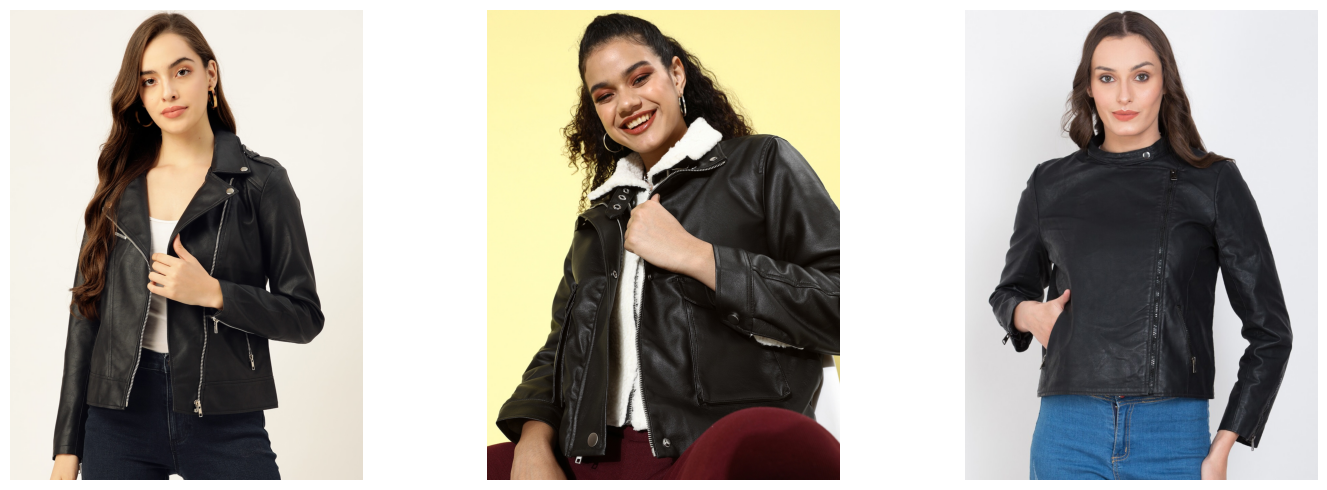

-------------------------------------------------------



dict_items([('ids', [['14455424', '15997714', '18153246']]), ('distances', [[0.29243114590644836, 0.30097609758377075, 0.3028116226196289]]), ('metadatas', [[{'Brand': 'Leather Retail', 'Colour': 'Black', 'Description': "Black graphic printed lightweight leather jacket with shoulder tabs, has a lapel collar, 3 pockets, has a zip closure, long sleeves, straight hemline, polyester lining and an attached belt at hemThe model (height 5'8) is wearing a size SOuter shell: Leather <br> Lining fabric: Polyester <br> Dry clean", 'Name': 'Leather Retail Women Black Graphic Print Lightweight Leather Jacket', 'Price_INR': 3999.0, 'Product_attributes': "{'Add-Ons': 'NA', 'Body Shape ID': '324,333,424', 'Body or Garment Size': 'Garment Measurements in', 'Character': 'NA', 'Closure': 'Zip', 'Collar': 'Lapel Collar', 'Fabric': 'Leather', 'Features': 'Lightweight', 'Hemline': 'Straight', 'Length': 'Regular', 'Lining Fabric': 'Polyester', 'Main Trend': 'NA', 'Number of Pockets': '3', 'Occasion': 'Casual

In [ ]:
# Query the fashion collection to retrieve relevant fashion items based on the user query
results = fashion_collection.query(
    query_texts=query,  # User query provided as input
    n_results=3  # Number of results to retrieve, in this case, the top 3 most relevant results
)


import matplotlib.pyplot as plt
import os
from PIL import Image

# Assuming you have already obtained the search results in the variable 'results'

# Extract the IDs of the fashion items from the search results
item_ids = results['ids'][0]  # Assuming the IDs are stored as the first element of the list

# Calculate the number of images
num_images = len(item_ids)

# Define the number of columns for the grid layout
num_cols = 3

# Calculate the number of rows needed based on the number of images and number of columns
num_rows = (num_images + num_cols - 1) // num_cols

# Set up the plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Display the images along with metadata
for i, item_id in enumerate(item_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    else:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"Image not found for item ID: {item_id}",
                     fontsize=12, ha='center', va='center')

# Hide any remaining empty subplots
for j in range(num_images, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


print("-------------------------------------------------------\n")
# Extract and display the items retrieved from the search operation
results.items()




In [ ]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()

# Check if the distance is greater than the threshold, if so, return results from the main collection
if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
    # Query the collection against the user query and return the results
    results = fashion_collection.query(
        query_texts=query,
        n_results=3
    )

    # Store the query in cache_collection as a document with respect to ChromaDB for future reference
    # Store retrieved text, ids, distances, and metadatas in cache_collection as metadatas, so they can be fetched easily if a query indeed matches to a query in cache
    Keys = []
    Values = []

    for key, val in results.items():
        if val is None:
            continue
        for i in range(len(val[0])):  # Iterate over the actual length of val
            Keys.append(str(key) + str(i))
            if len(val[0]) > i:  # Check if the current index exists in val
                Values.append(str(val[0][i]))

    cache_collection.add(
        documents=[query],
        ids=[query],
        metadatas=dict(zip(Keys, Values))
    )

    # Print message indicating the results are found in the main collection
    print("Not found in cache. Found in the main collection.")

    # Construct a DataFrame from the query results
    result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs": results["ids"][0]}
    results_df = pd.DataFrame.from_dict(result_dict)


# If the distance is less than the threshold, return results from the cache
elif cache_results['distances'][0][0] <= threshold and cache_results['ids']:
    cache_result_dict = cache_results['metadatas'][0][0]

    # Loop through each inner list and then through the dictionary
    for key, value in cache_result_dict.items():
        if 'ids' in key:
            ids.append(value)
        elif 'documents' in key:
            documents.append(value)
        elif 'distances' in key:
            distances.append(value)
        elif 'metadatas' in key:
            metadatas.append(value)

    # Print message indicating the results are found in the cache
    print("Found in cache!")

    # Create a DataFrame from the cached results
    results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
    })
else:
    # Print message indicating no valid results found in cache
    print("No valid results found in cache!")



Not found in cache. Found in the main collection.


Query: 
I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit.
Preferably in size XL


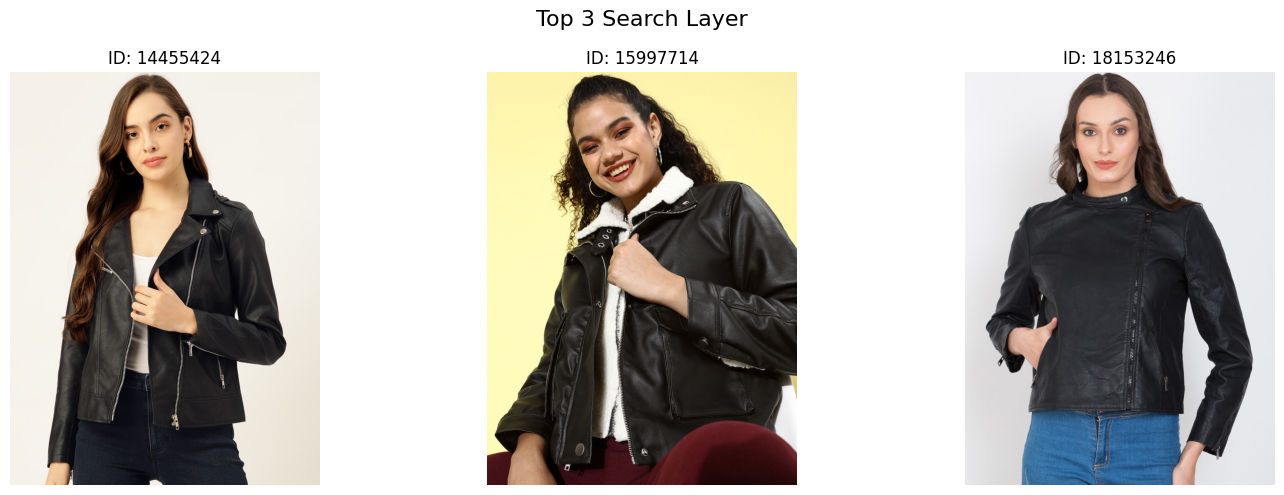

In [ ]:
##For Screenshot

# Define the function to print query with a prefix and separator
def print_query_with_separator(prefix, query):
    # Print the prefix
    print(prefix)
    # Insert a newline character after every full stop
    query_with_newlines = query.replace(". ", ".\n")
    # Print the modified query
    print(query_with_newlines)

# Print the query with prefix and separator
print_query_with_separator("Query: ", query)

# Print the IDs from the results DataFrame
##print("IDs:")
#print(results_df['IDs'])


# Display images corresponding to the IDs side by side
num_images = len(results_df['IDs'])
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Set the title of the plot as the user query
fig.suptitle("Top 3 Search Layer", fontsize=16)

for i, item_id in enumerate(results_df['IDs']):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()


In [ ]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Brand': 'Leather Retail', 'Colour': 'Black',...",Black graphic printed lightweight leather jack...,0.292431,14455424
1,"{'Brand': 'Tokyo Talkies', 'Colour': 'Black', ...","Black solid leather jacket with zip detail, ha...",0.300976,15997714
2,"{'Brand': 'Justanned', 'Colour': 'Black', 'Des...","Black solid leather jacket with zip detail, ...",0.302812,18153246


In [ ]:
# Query the cache collection for results matching the user query
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

# Print the cache results
cache_results


{'ids': [["I'm searching for a versatile black leather jacket, suitable for various occasions and effortlessly complementing any outfit. Preferably in size XL"]],
 'distances': [[0.0]],
 'metadatas': [[{'distances0': '0.29243114590644836',
    'distances1': '0.30097609758377075',
    'distances2': '0.3028116226196289',
    'documents0': "Black graphic printed lightweight leather jacket with shoulder tabs, has a lapel collar, 3 pockets, has a zip closure, long sleeves, straight hemline, polyester lining and an attached belt at hemThe model (height 5'8) is wearing a size SOuter shell: Leather <br> Lining fabric: Polyester <br> Dry clean",
    'documents1': "Black solid leather jacket with zip detail, has a mock collar, 2 pockets ,has a zip closure, long sleeves, hem with toggle hemline, without liningFaux Leather<br>Machine washThe model (height 5'8) is wearing a size S",
    'documents2': "Black solid leather jacket  with zip detail,  has a mandarin collar,  2  pockets ,has a zip closur



## 5.Re-Ranking with a Cross Encoder




Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>


In [ ]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
# Create input pairs for the cross encoder, consisting of each query paired with each response
cross_inputs = [[query, response] for response in results_df['Documents']]

# Generate cross-encoder scores for the input pairs
cross_rerank_scores = cross_encoder.predict(cross_inputs)

# Display the cross-encoder scores
cross_rerank_scores


array([-2.0272617, -1.1715635, -1.2628734], dtype=float32)

In [ ]:
# Add the cross-encoder scores to the results DataFrame
results_df['Reranked_scores'] = cross_rerank_scores

# Display the updated results DataFrame
results_df


,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Brand': 'Leather Retail', 'Colour': 'Black',...",Black graphic printed lightweight leather jack...,0.292431,14455424,-2.027262
1,"{'Brand': 'Tokyo Talkies', 'Colour': 'Black', ...","Black solid leather jacket with zip detail, ha...",0.300976,15997714,-1.171564
2,"{'Brand': 'Justanned', 'Colour': 'Black', 'Des...","Black solid leather jacket with zip detail, ...",0.302812,18153246,-1.262873


In [ ]:
# Return the top 3 results from semantic search based on the Distance
top_3_semantic = results_df.sort_values(by='Distances', ascending=False)[:3]

# Display the top 3 semantic search results
top_3_semantic

,Metadatas,Documents,Distances,IDs,Reranked_scores
2,"{'Brand': 'Justanned', 'Colour': 'Black', 'Des...","Black solid leather jacket with zip detail, ...",0.302812,18153246,-1.262873
1,"{'Brand': 'Tokyo Talkies', 'Colour': 'Black', ...","Black solid leather jacket with zip detail, ha...",0.300976,15997714,-1.171564
0,"{'Brand': 'Leather Retail', 'Colour': 'Black',...",Black graphic printed lightweight leather jack...,0.292431,14455424,-2.027262


In [ ]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank

,Metadatas,Documents,Distances,IDs,Reranked_scores
1,"{'Brand': 'Tokyo Talkies', 'Colour': 'Black', ...","Black solid leather jacket with zip detail, ha...",0.300976,15997714,-1.171564
2,"{'Brand': 'Justanned', 'Colour': 'Black', 'Des...","Black solid leather jacket with zip detail, ...",0.302812,18153246,-1.262873
0,"{'Brand': 'Leather Retail', 'Colour': 'Black',...",Black graphic printed lightweight leather jack...,0.292431,14455424,-2.027262


In [ ]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas","IDs"]]
top_3_RAG

,Documents,Metadatas,IDs
1,"Black solid leather jacket with zip detail, ha...","{'Brand': 'Tokyo Talkies', 'Colour': 'Black', ...",15997714
2,"Black solid leather jacket with zip detail, ...","{'Brand': 'Justanned', 'Colour': 'Black', 'Des...",18153246
0,Black graphic printed lightweight leather jack...,"{'Brand': 'Leather Retail', 'Colour': 'Black',...",14455424


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with brand,name and other information, rather than returning whole pages/chunks in a table format.

### Generation Layer

Based on your search criteria for a versatile black leather jacket in size XL, here are the top 3 relevant results that match your request:

1. **Black Solid Leather Jacket with Zip Detail**:
   - Description: A black solid leather jacket featuring zip detail, making it a stylish and versatile choice.
   - Brand: Not specified in the metadata.
   - ID: 15997714

2. **Black Solid Leather Jacket with Zip Detail**:
   - Description: Another black solid leather jacket with zip detail, offering a classic and timeless look suitable for various occasions.
   - Brand: Not specified in the metadata.
   - ID: 18153246

3. **Black Graphic Printed Lightweight Leather Jacket**:
   - Description: This jacket combines black leather with graphic printing, creating a unique and fashionable piece.
   - Brand: Not specified in the metadata.
   - ID: 14455424

Based on the provided descriptions, the first two black solid leather jackets with zip detail seem to align closely with your search for a versatil

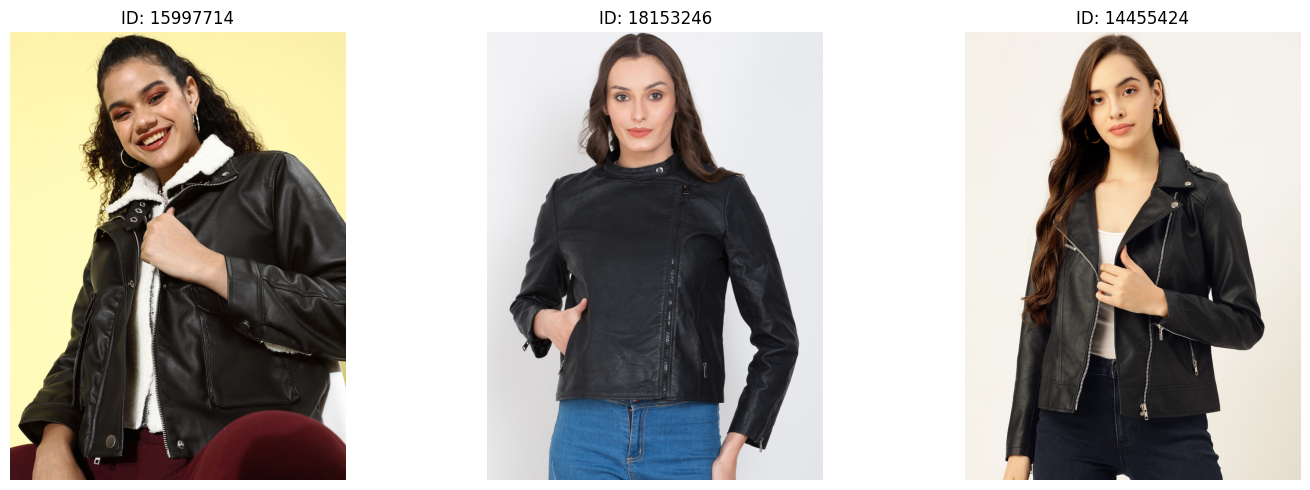

In [ ]:
def generate_response_fashion(query, top_3_RAG):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
        {"role": "system", "content":  "You are a helpful AI assistant in the fashion domain, specialized in providing accurate answers to fashion-related queries."},
        {"role": "user", "content": f"""You have received a query from a user looking for fashion-related information. The query is: "{query}".
                                        Additionally, you have obtained the top 3 relevant results from the fashion dataset in the dataframe '{top_3_RAG}'.

                                        The 'Documents' column in this dataframe contains descriptions of fashion items, and the 'Metadatas' column contains additional information such as item name, brand.

                                        Your task is to use the information provided in '{top_3_RAG}' to generate a response to the query "{query}". Ensure that your response is informative and relevant to the user's query. Utilize the metadata to cite the relevant fashion items.

                                        Please adhere to the following guidelines:
                                        1. Provide accurate and relevant information based on the user query and the top 3 search results.
                                        2. You may use any relevant details from the dataframe to craft your response.
                                        3. If any of the fashion items contain tables or structured information, format and present it clearly.
                                        4. Use the metadata to cite the names, brands of the relevant fashion items.
                                        5. If you are unable to provide a complete answer, offer guidance on where the user can find further information within the cited fashion items.
                                        6. As a user-facing assistant, focus on delivering a direct and concise response without delving into technical details.
                                        7. Please note that detailed price and rating information might change from time to time. For more details,you should recommend to visit our website page.

                                        Your response should directly address the user's query and include citations for the referenced fashion items. Present the information in a well-organized and easily understandable format.
                                        """},
    ]

    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    # Extracting p_ids directly from the 'IDs' column in top_3_RAG
    p_ids = top_3_RAG['IDs'].head(3).tolist()

    # Returning response and p_ids
    return response.choices[0].message.content, p_ids

# Generate response and p_ids based on the provided query and top_3_RAG DataFrame
response, p_ids = generate_response_fashion(query, top_3_RAG)

# Print the response
print(response)



# Display the images corresponding to the IDs obtained from the response side by side
num_images = len(p_ids)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, item_id in enumerate(p_ids):
    # Construct the path to the image file
    image_path = os.path.join(images_folder_path, str(item_id) + '.jpg')

    # Check if the image file exists
    if os.path.exists(image_path):
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"ID: {item_id}")
    else:
        print(f"Image not found for item ID: {item_id}")

plt.tight_layout()
plt.show()


## Conclusion

- The generation layer produces more detailed and comprehensible responses compared to the search layer.
- Unlike the search layer, which relies on keyword matching, the generation layer uses advanced AI like GPT-3.5 to deliver context-aware, dynamic replies.
- The generation layer offers nuanced explanations and engaging content in natural language, improving user experience.
- Its adaptability to various query formats and customization enhances its value for complex information tasks.
- Overall, while the search layer is efficient for retrieving information, the generation layer excels in providing high-quality, readable, and tailored responses.
